Predictive Modeling for Risk-Based Pricing

In [14]:
# --- 1. Setup & Imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import joblib

In [15]:
# --- 2. Load Prepared Data (from Task 3) ---
policy_summary = pd.read_csv("../eda_outputs/policy_summary.csv")
#print(policy_summary.head)

In [16]:
# --- 3. Filter for Policies with Claims for Claim Severity---
model_data = policy_summary[policy_summary['HasClaim'] == True].copy()
#print(model_data.head)

print(model_data.columns)


Index(['PolicyID', 'TotalPremium', 'TotalClaims', 'HasClaim', 'Province',
       'PostalCode', 'Gender', 'ClaimFrequency', 'Margin', 'ClaimSeverity'],
      dtype='object')


In [17]:
# --- 4. Feature Engineering ---
model_data = model_data.drop(columns=['PolicyID', 'HasClaim'], errors='ignore')

# Encode known categorical columns
model_data = pd.get_dummies(model_data, columns=['Province', 'PostalCode'], drop_first=True)

# Step 1: Identify remaining object (categorical) columns like Gender
categorical_cols = model_data.select_dtypes(include='object').columns.tolist()
print("Categorical columns to encode:", categorical_cols)

# Step 2: Apply one-hot encoding to those
if categorical_cols:
    model_data_encoded = pd.get_dummies(model_data, columns=categorical_cols, drop_first=True)

# Step 3: Reconfirm that everything is numeric
print("Final dtypes:\n", model_data.dtypes)

# --- Define features and target ---
X = model_data_encoded.drop(columns=['ClaimSeverity'])
y = model_data_encoded['ClaimSeverity']

Categorical columns to encode: ['Gender']
Final dtypes:
 TotalPremium              float64
TotalClaims               float64
Gender                     object
ClaimFrequency              int64
Margin                    float64
ClaimSeverity             float64
Province_KwaZulu-Natal       bool
Province_Limpopo             bool
Province_Mpumalanga          bool
Province_North West          bool
Province_Western Cape        bool
PostalCode_84                bool
PostalCode_122               bool
PostalCode_125               bool
PostalCode_183               bool
PostalCode_621               bool
PostalCode_902               bool
PostalCode_1021              bool
PostalCode_1085              bool
PostalCode_1401              bool
PostalCode_1431              bool
PostalCode_1475              bool
PostalCode_1496              bool
PostalCode_1541              bool
PostalCode_1744              bool
PostalCode_1748              bool
PostalCode_1759              bool
PostalCode_2000          

In [18]:
# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# --- 6. Model Training & Evaluation ---
from math import sqrt
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)    
    mse = mean_squared_error(y_test, preds)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, preds)
    print(f"{name} Model - RMSE: {rmse:.2f}, R2: {r2:.3f}")
    return model


linreg = evaluate_model("Linear Regression", LinearRegression())
rf = evaluate_model("Random Forest", RandomForestRegressor(random_state=42))


xgb = evaluate_model("XGBoost", XGBRegressor(random_state=42, verbosity=0))

Linear Regression Model - RMSE: 0.00, R2: 1.000
Random Forest Model - RMSE: 12106.17, R2: 0.945
XGBoost Model - RMSE: 14178.24, R2: 0.924


In [20]:
# Check all column types
print(model_data_encoded.dtypes)

# Identify all object (categorical) columns, including Gender
categorical_cols = model_data_encoded.select_dtypes(include='object').columns.tolist()
print("Categorical columns to encode:", categorical_cols)

# Apply one-hot encoding to all object columns
if categorical_cols:
    model_data_encoded = pd.get_dummies(model_data, columns=categorical_cols, drop_first=True)

# Reconfirm that everything is numeric
print(model_data_encoded.dtypes)

# Proceed with modeling
linreg = evaluate_model("Linear Regression", LinearRegression())
rf = evaluate_model("Random Forest", RandomForestRegressor(random_state=42))
xgb = evaluate_model("XGBoost", XGBRegressor(random_state=42, verbosity=0))


TotalPremium              float64
TotalClaims               float64
ClaimFrequency              int64
Margin                    float64
ClaimSeverity             float64
Province_KwaZulu-Natal       bool
Province_Limpopo             bool
Province_Mpumalanga          bool
Province_North West          bool
Province_Western Cape        bool
PostalCode_84                bool
PostalCode_122               bool
PostalCode_125               bool
PostalCode_183               bool
PostalCode_621               bool
PostalCode_902               bool
PostalCode_1021              bool
PostalCode_1085              bool
PostalCode_1401              bool
PostalCode_1431              bool
PostalCode_1475              bool
PostalCode_1496              bool
PostalCode_1541              bool
PostalCode_1744              bool
PostalCode_1748              bool
PostalCode_1759              bool
PostalCode_2000              bool
PostalCode_2040              bool
PostalCode_2062              bool
PostalCode_206

In [21]:
categorical_cols = model_data_encoded.select_dtypes(include='object').columns.tolist()

# Convert all categorical to numeric using category codes (ordinal encoding)
for col in categorical_cols:
    model_data_encoded[col] = model_data_encoded[col].astype('category').cat.codes

# split:
from sklearn.model_selection import train_test_split
X = model_data_encoded.drop(columns=['ClaimSeverity'])
y = model_data_encoded['ClaimSeverity']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



SHAP Summary for XGBoost Model:


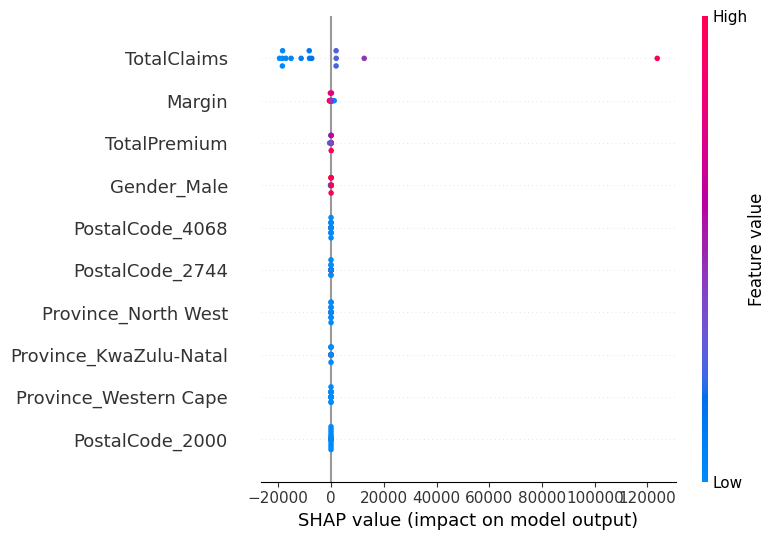

['xgb_claim_severity_model.pkl']

In [22]:
# --- 7. Model Interpretability (SHAP) ---
print("\nSHAP Summary for XGBoost Model:")

X_test = X_test.astype(np.float64)
explainer = shap.Explainer(xgb, X_test)
shap_values = explainer(X_test)

# Plot top 10 most important features
shap.summary_plot(shap_values, X_test, max_display=10)

# Save trained Model---
joblib.dump(xgb, "xgb_claim_severity_model.pkl")
